# Zombie atakują!!!

![zombies](img/zombie.jpeg)

Świat atakują zombie. Symulacja pozwala prześledzić losy ludzkości.
Parametry modelu:
* wielkość populacji, standardowo 100000
* startowy procent zombie w populacji, standardowo 2.5%
* rozkład doświadczenia w populacji, doświadczenie może mieć wartość od 0 do 90 i wyznacza prawdopodobieństwo zabicia zombie w przypadku spotkania, standardowo rozkład jest równomierny - 10 równych grup z doświadczeniem od 0 do 90


Inspirowane przez: http://www.econometricsbysimulation.com/2013/04/the-dynamics-of-zombie-apocalypse.html

In [347]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [338]:
def pairup(x, unmatched=True):
    if type(x) == int:
        x = np.arange(x)
    xleng = x.size
    hleng = np.int(np.floor(xleng / 2))
    np.random.shuffle(x)
    if xleng % 2 and unmatched:
        t = x[-1]
        x = np.delete(x, -1)
        x = x.reshape(hleng, 2)
        x = np.vstack((x, (t, t)))
    else:
        x = x.reshape(hleng, 2)
    return x

In [355]:
def sim(population=10000, infected=0.025, exp=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)):
    types = np.arange(0, 100, 10, dtype=int)
    freq = np.array(exp)
    htypes = np.array([types, freq])

    perc = np.round(freq / sum(freq) * population).astype(int)
    walking = np.repeat(types, perc)
    nselected = np.int(np.round(population * infected))

    zombies = np.random.choice(np.arange(population), nselected, replace=False)
    healthy = np.delete(walking, zombies)
    x = np.repeat(-77, nselected)
    walking = np.concatenate((healthy, x))

    perc_zombies = np.mean(walking == -77)

    nthings = walking.size
    nthings_vector = np.array([nthings])
    nzombies = np.array([np.sum(walking == -77)])

    nhumans = np.array([np.sum(walking != -77)])
    nhumans0 = np.sum(walking == 0)
    nhumans10 = np.sum(walking == 10)
    nhumans20 = np.sum(walking == 20)
    nhumans30 = np.sum(walking == 30)
    nhumans40 = np.sum(walking == 40)
    nhumans50 = np.sum(walking == 50)
    nhumans60 = np.sum(walking == 60)
    nhumans70 = np.sum(walking == 70)
    nhumans80 = np.sum(walking == 80)
    nhumans90 = np.sum(walking == 90)

    max_rounds = 45
    i = 0
    while (nzombies[i] and nhumans[i] and i < max_rounds):
        i += 1
        encounter = pairup(nthings)
        types = np.vstack((walking[encounter[:, 0]], walking[encounter[:, 1]])).T
        conflict = np.zeros(types.shape, dtype=int)
        hvz = (types[:, 1] == -77) & (types[:, 0] >= 0)
        temp = np.copy(types)
        types[hvz, 0] = temp[hvz, 1]
        types[hvz, 1] = temp[hvz, 0]

        temp = np.copy(encounter)
        encounter[hvz, 0] = temp[hvz, 1]
        encounter[hvz, 1] = temp[hvz, 0]
        zvh = (types[:, 0] == -77) & (types[:, 1] >= 0)
        # win.zvh = (runif(sum(zvh))>types[zvh,2]/100)
        win = (np.random.uniform(size=sum(zvh)) > types[zvh, 1] / 100)
        conflict[zvh, 0] = np.where(win, 4, 2)
        conflict[zvh, 1] = np.where(win, 1, 4)

        conflict[types[:, 0] == types[:, 1],] = 3
        conflict[(types[:, 0] >= 0) & (types[:, 1] >= 0),] = 3

        walking[encounter[conflict == 1]] = -77
        walking = np.delete(walking, [encounter[conflict == 2]])

        perc_zombies = np.append(perc_zombies, np.mean(walking == -77))

        # Total population (living and dead)
        nthings = len(walking)
        nthings_vector = np.append(nthings_vector, nthings)

        # Count the number of zombies
        nzombies = np.append(nzombies, sum(walking == -77))

        # Count the number of humans and save them to vectors
        nhumans = np.append(nhumans, sum(walking != -77))

        nhumans0 = np.append(nhumans0, sum(walking == 0))
        nhumans10 = np.append(nhumans10, sum(walking == 10))
        nhumans20 = np.append(nhumans20, sum(walking == 20))
        nhumans30 = np.append(nhumans30, sum(walking == 30))
        nhumans40 = np.append(nhumans40, sum(walking == 40))
        nhumans50 = np.append(nhumans50, sum(walking == 50))
        nhumans60 = np.append(nhumans60, sum(walking == 60))
        nhumans70 = np.append(nhumans70, sum(walking == 70))
        nhumans80 = np.append(nhumans80, sum(walking == 80))
        nhumans90 = np.append(nhumans90, sum(walking == 90))

    result = {'humans':nhumans, 'zombies': nzombies,'humans0':nhumans0,'humans10':nhumans10,'humans20':nhumans20,'humans30':nhumans30,
             'humans40':nhumans40,'humans50':nhumans50,'humans60':nhumans60,'humans70':nhumans70,'humans80':nhumans80,'humans90':nhumans90}
    return result

In [384]:
def plot_simulation(dict):
    df=pd.DataFrame.from_dict(dict)
    humans_p = ['humans'+str(i) for i in range(0,100,10)]
    plt.plot(df['zombies'],label='Z')
    plt.plot(df[humans_p])

## Jeśli osób z doświadczeniem jest mało, zombie opanowują świat :(

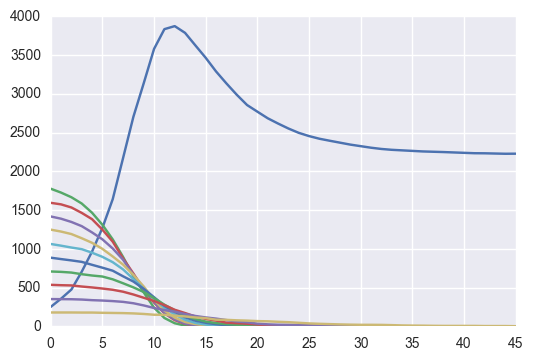

In [385]:
d1=sim(exp=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5])
plot_simulation(d1)

## Jeśli mamy populację o równomiernie rozłożonym doświadczeniu, zombie nie mają szans :) Ale osób, które mają małe doświadczenie przeżywa mało :(

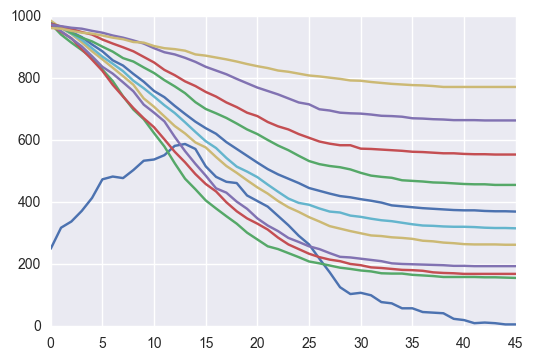

In [386]:
d2=sim()
plot_simulation(d2)